In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from PIL import Image, UnidentifiedImageError
import requests

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:


data_dir = "PetImages"
output_dir = "cats_vs_dogs_v3/train"


In [3]:

def is_image_valid(filepath):
    try:
        img = Image.open(filepath)
        img.verify()
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(180, 180),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=123
)

class_names = train_ds.class_names

for i, (images, labels) in enumerate(train_ds.unbatch().take(3000)):
    label = labels.numpy()
    class_name = class_names[label]
    save_dir = os.path.join(output_dir, class_name)
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{class_name}_{i}.jpg")
    tf.keras.preprocessing.image.save_img(filename, images.numpy())

Found 24998 files belonging to 2 classes.
Using 19999 files for training.


In [4]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.10,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    output_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    output_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 2401 images belonging to 2 classes.
Found 599 images belonging to 2 classes.


In [9]:



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/20


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 63s 711ms/step - accuracy: 0.6710 - loss: 0.6930 - val_accuracy: 0.9165 - val_loss: 0.2032
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 413ms/step - accuracy: 0.9131 - loss: 0.2039 - val_accuracy: 0.9366 - val_loss: 0.1863
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.9241 - loss: 0.2067 - val_accuracy: 0.9165 - val_loss: 0.1939
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 446ms/step - accuracy: 0.9344 - loss: 0.1592 - val_accuracy: 0.9282 - val_loss: 0.1768
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 438ms/step - accuracy: 0.9407 - loss: 0.1665 - val_accuracy: 0.9165 - val_loss: 0.1896
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 482ms/step - accuracy: 0.9347 - loss: 0.1941 - val_accuracy: 0.9382 - val_loss: 0.1450
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - accuracy: 0.9401 - loss: 0.1570 - val_accuracy: 0.9366 - val_loss: 0.1584
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 429ms/step - accuracy: 0.9521 - loss: 0.1283 - val_accuracy: 0.926

In [10]:

model.save('cats_vs_dogs_transfer.keras')
model = tf.keras.models.load_model('cats_vs_dogs_transfer.keras')


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.9377 - loss: 0.1389
Validation Loss: 0.1713
Validation Accuracy: 92.65%


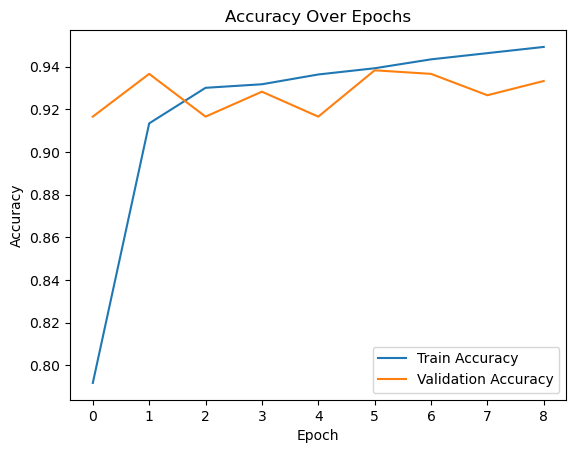

In [12]:


loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 386ms/step


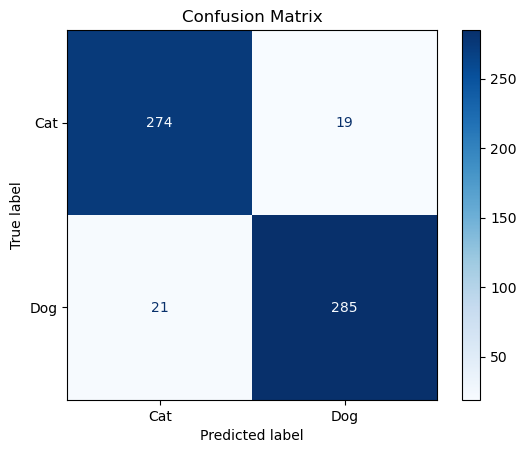


Classification Report:
              precision    recall  f1-score   support

         Cat       0.93      0.94      0.93       293
         Dog       0.94      0.93      0.93       306

    accuracy                           0.93       599
   macro avg       0.93      0.93      0.93       599
weighted avg       0.93      0.93      0.93       599



In [13]:

y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype("int").flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [14]:

def predict_and_show_image(img_url, model, class_indices, target_size=(150, 150), threshold=0.5):
    img = Image.open(requests.get(img_url, stream=True).raw).resize(target_size)
    image_array = image.img_to_array(img)
    img_array = np.expand_dims(image_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class_index = int(prediction[0][0] > threshold)
    classes = {v: k for k, v in class_indices.items()}
    predicted_class = classes[predicted_class_index]
    plt.imshow(image_array.astype("uint8"))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


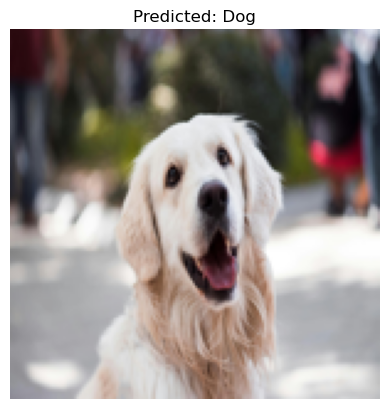

'Dog'

In [15]:

img_url = 'https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg'
predict_and_show_image(img_url, model, train_generator.class_indices)
